# Project: Wrangle and Analyze the WeRateDogs Twitter Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gathering Data</a></li>
<li><a href="#assess">Assessing Data</a></li>
<li><a href="#clean">Cleaning Data</a></li>
<li><a href="#analyze">Analyzing Data</a></li>
<li><a href="#conclusion">Conclusions</a></li>
</ul>

<a id='intro'></a>
# Introduction

> This dataset is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

## Goal

>**Wrangle WeRateDogs Twitter data, gather additional data, assess and then clean the data to create interesting and trustworthy analyses and visualizations.**

## The Data

### Enhanced Twitter Archive

>The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets. The archive contains each tweet's text, which is used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, the ones with ratings have been filtered.

### Additional Data via the Twitter API

>Retweet count and favorite count are two of the notable column omissions in the Twitter archive. This additional data needs to be gathered/queried from Twitter's API.

### Image Predictions File

>This is a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images). Need to clean, assess and use this table for further analysis

## Questions to Analyze: 
- Which are the top tweets favorited by most users?
- Which are the most common breeds found by the neural network?
- For which breeds is the algorithm most and least confident in its prediction?
- Which are the most common names of dogs?
- Which dog breeds have the most number of retweets and favorites? 

<a id='gather'></a>
## Part I - Gathering Data

Data will be gathered from three sources:

- **The WeRateDogs Twitter archive**. The twitter_archive_enhanced.csv file was provided.

- **The tweet image predictions**, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network.

- **Twitter API and Python's Tweepy library** to gather each tweet's retweet count and favorite count

In [1]:
#import all the necessary libraries
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import time
import re
from timeit import default_timer as timer
from IPython.display import Image
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
#read twitter-archive file 
archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


**Gather `The tweet image predictions`, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network from a URL using the Requests library.**

In [3]:
#download the image-predictions file from the url provided with requests library
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url) 
response

<Response [200]>

In [4]:
#open the image_predictions file
with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)

In [5]:
#read in the tsv file as dataframe
img_df = pd.read_csv('image-predictions.tsv', sep = '\t')
img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
# Query the Twitter API for each tweet's JSON data using Python's Tweepy library
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth_handler = auth, 
                 parser = tweepy.parsers.JSONParser(), 
                 wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)

In [7]:
#create a list of all the tweet_ids
tweet_ids = archive_df['tweet_id'].tolist()

In [15]:
# Store each tweet's entire set of JSON data in a file called tweet_json.txt file
start = timer() # Sets a timer start count

with open('tweet_json.txt', 'w') as file: #Opens a text file to write JSON data
    for tweet_id in tweet_ids:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended') #Gets the tweet data from twitter API
            file.write(json.dumps(tweet) + '\n') # Writes the JSON data into the .txt file
        
        
        except Exception as e: # Prints the error exceptions of the data missing from the tweet_id
            print(str(tweet_id) + "_" + str(e))
        
end = timer() # Sets a timer end count
print(end - start)

888202515573088257_[{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921_[{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937_[{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745_[{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329_[{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744_[{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320_[{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130_[{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560_[{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705_[{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984_[{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648_[{'code': 144, 'message': 'No status found with that ID.'}]
837366284874571778_[{'code': 144, 'message': 'No sta

In [6]:
# Read the .txt file line by line into a pandas DataFrame with tweet ID, retweet count, and favorite count

selected_cols = []

with open('tweet_json.txt', 'r') as file: 
    for i in file:
        json_data = json.loads(i)
        selected_cols.append({'tweet_id' : json_data['id'],
                              'favorites' : json_data['favorite_count'],
                              'retweets' : json_data['retweet_count']
                              })

api_df = pd.DataFrame(selected_cols, columns = ['tweet_id', 'favorites', 'retweets']) #Creates a dataframe with the mentioned columns

In [7]:
# Print the first 5 rows to check the dataset
api_df.head()

,tweet_id,favorites,retweets
0,892420643555336193,36240,7712
1,892177421306343426,31257,5699
2,891815181378084864,23535,3779
3,891689557279858688,39536,7876
4,891327558926688256,37751,8485


<a id='assess'></a>
## Part II - Assessing Datasets

In [10]:
# Visually assess the twitter_archive dataset
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [11]:
# Visually assess the image_predictions dataset
img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
# Show detailed information of each column in the twitter_archive dataframe
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
# Show detailed information of each column in the image_prediction dataframe
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
# Show detailed information of each column in the twitter_api dataframe
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id     2331 non-null int64
favorites    2331 non-null int64
retweets     2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [17]:
# Check for any duplicated values in twitter_archive dataset
archive_df.duplicated().sum()

0

In [18]:
# Check for any duplicated values in image_predictions dataset
img_df.duplicated().sum()

0

In [19]:
# Check for any duplicated values in twitter_api dataset
api_df.duplicated().sum()

0

In [61]:
# Check for valid names in the archive dataset
archive_df.name.value_counts().head()

None       745
a          55 
Charlie    12 
Cooper     11 
Lucy       11 
Name: name, dtype: int64

In [109]:
# Show descriptive statistics of twitter_archive dataframe
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [110]:
# Show descriptive statistics of image predictions dataframe
img_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [111]:
# Show descriptive statistics of twitter api dataframe
api_df.describe()

,tweet_id,favorites,retweets
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7567.558988,2705.819820
std,6.823170e+16,11746.514299,4575.538468
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1319.000000,548.000000
50%,7.182469e+17,3290.000000,1268.000000
75%,7.986692e+17,9264.500000,3143.500000
max,8.924206e+17,156335.000000,77862.000000


### Quality Issues
##### `Twitter_Archive` table
- Null values in the dataset or Unnecessary columns
- Incorrect dog names such as 'None', 'a', 'an', 'such'
- Retweets in the dataset
- Erroneous datatypes of timestamp
- Erroneous datatypes of ID columns
- Erroneous datatypes of the two rating columns
- Incorrect ratings recorded from the text
- Timestamp format unclean

##### `Image_predictions` table
- Lowercase and Uppercase dog types
- Non-descriptive column names

### Tidiness Issues

- Incorrect columns for Dog status in `Twitter_archive` table
- Single type of observational unit forming multiple tables

<a id='clean'></a>
## Part III - Data Cleaning

### Quality Issues

### **1. Null values in the dataset or Unnecessary columns**

***Define:*** 
The ID columns (except tweet_id) in the `Twitter_archive` table have more than 90% of the values as Null. Thus need to remove these columns as they won't be used in further analysis

***Code:***

In [8]:
# Create a copy of the original datasets
archive_df1 = archive_df.copy()
img_df1 = img_df.copy()
api_df1 = api_df.copy()
# Drop columns with null values as they won't be used in analysis
archive_df1.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'source'], axis = 1, inplace = True)

***Test:***

In [39]:
# Check for the updated values
archive_df1.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,None,None,None,None


### **2. Incorrect dog names such as 'None', 'a', 'an', 'such'**

***Define:*** 
Replace the incorrect names from the name column in the `Twitter_archive` table with Null values

***Code:***

In [9]:
# Replace all the dog names beginning with lowercase letters to Null values
incorrect_names = archive_df1.name.str.islower()
column_name = 'name'
archive_df1.loc[incorrect_names, column_name] = np.nan

In [10]:
# Replace all the None values with Null
archive_df1.name.replace('None', np.nan, inplace = True)

***Test:***

In [12]:
# Check for the value counts of each name
archive_df1.name.value_counts().head()

Charlie    12
Lucy       11
Cooper     11
Oliver     11
Tucker     10
Name: name, dtype: int64

### 3. Retweets in the Dataset

***Define:***
Search for the 'RT @' string in the text data and remove the retweets in the dataset

***Code:***

In [11]:
# Exclude all the rows that contains 'RT @'(as these are retweets) string in the text columns
archive_df1 = archive_df1[~archive_df1['text'].str.match('RT @')]

***Test:***

In [12]:
# Check if any retweets are left out
archive_df1[archive_df1['text'].str.match('RT @')]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### 4. `timestamp` column is object datatype

***Define:***
Change the datatype of timestamp from object to datetime

***Code:***

In [13]:
# Convert timestamp from object to datetime
archive_df1['timestamp'] = pd.to_datetime(archive_df1['timestamp'], errors = 'coerce', format = "%Y-%m-%d %H:%M:%S")

***Test:***

In [26]:
# Check for the conversion
archive_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  1391 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 220.9+ KB


### 5. `tweet_id` column is of data type *int*

***Define:***
Change the datatype of **`tweet_id`** from **int** to **string**

***Code:***

In [14]:
# Convert tweet_id from int to string
archive_df1.tweet_id = archive_df1.tweet_id.astype(str)
img_df1.tweet_id = img_df1.tweet_id.astype(str)
api_df1.tweet_id = api_df1.tweet_id.astype(str)

***Test:***

In [39]:
#Check the conversion
print(archive_df1.tweet_id.dtype)
print(img_df1.tweet_id.dtype)
print(api_df1.tweet_id.dtype)

object
object
object


### 6. `rating_numerator` and `rating_denominator` column are of data type *int*

***Define:***
Change the datatype of **`rating_numerator`** and **`rating_denominator`** from **int** to **float**

***Code:***

In [37]:
#Convert ratings from int to float
archive_df1.rating_numerator = archive_df1.rating_numerator.astype(float)
archive_df1.rating_denominator = archive_df1.rating_denominator.astype(float)

***Test:***

In [40]:
# Check the conversion
print(archive_df1.rating_numerator.dtype)
print(archive_df1.rating_denominator.dtype)

float64
float64


### 7. Incorrect ratings recorded from the text

***Define:*** Identify the incorrect ratings and extract the correct ratings using regular expressions. Replace the remaining invalid ratings.  

In [29]:
archive_df1.rating_numerator.value_counts()

12.0      500
10.0      442
11.0      426
13.0      307
9.0       156
8.0        98
7.0        54
14.0       43
5.0        36
6.0        32
3.0        19
4.0        17
2.0         9
1.0         8
0.0         2
420.0       2
84.0        1
24.0        1
27.0        1
15.0        1
17.0        1
960.0       1
143.0       1
99.0        1
666.0       1
121.0       1
182.0       1
165.0       1
45.0        1
75.0        1
204.0       1
1776.0      1
80.0        1
88.0        1
144.0       1
26.0        1
20.0        1
44.0        1
60.0        1
50.0        1
Name: rating_numerator, dtype: int64

In [46]:
# Check for the invalid ratings from the complete text
pd.set_option('display.max_colwidth', -1)
print(archive_df1.query('rating_numerator == 960')['text'])
print(archive_df1.query('rating_numerator == 50')['text'])

Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)


***Code:***

In [42]:
# Extract all the ratings from the text column and assign to the rating_numerator column
archive_df1['rating_numerator'] = archive_df1.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

In [43]:
# Replace the rating 960 from the numerator with 13 as mentioned in the text
archive_df1.rating_numerator.replace(960, 13, inplace = True)

In [44]:
# Replace the rating 00 from the denominator with 10 as mentioned in the text
archive_df1.rating_denominator.replace(0, 10, inplace = True)

***Test:***

In [45]:
# Check for the numerator ratings
archive_df1.rating_numerator.value_counts()

12       500
10       442
11       426
13       307
9        156
8        98 
7        53 
14       43 
5        34 
6        32 
3        19 
4        17 
2        9  
1        8  
0        2  
420      2  
11.27    1  
44       1  
204      1  
84       1  
9.5      1  
960      1  
143      1  
24       1  
20       1  
1776     1  
99       1  
9.75     1  
121      1  
182      1  
165      1  
60       1  
13.5     1  
15       1  
11.26    1  
45       1  
80       1  
17       1  
88       1  
144      1  
007      1  
50       1  
666      1  
Name: rating_numerator, dtype: int64

### 8. Inconsistent upper and lowercase names of dog type in the `image_predictions` table
***Define:*** Convert all the dog breeds to lowercase

***Code:***

In [20]:
# Make all the dog types lowercase
img_df1.p1 = img_df1.p1.str.lower()
img_df1.p2 = img_df1.p2.str.lower()
img_df1.p3 = img_df1.p3.str.lower()

***Test:***

In [47]:
img_df1.head()

,tweet_id,jpg_url,img_num,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


### 9. Non-descriptive column names in the `image_predictions` table

***Define:***
Change Non-descriptive column names (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog) into descriptive column names (first_prediction, first_confidence, first_dog, second_prediction, second_confidence, second_dog, third_prediction, third_confidence, third_dog) consecutively in image_predictions dataframe

***Code:***

In [21]:
img_df1.rename(index = str, columns={"p1": "first_prediction",
                                        "p1_conf": "first_confidence",
                                        "p1_dog": "first_dog",
                                        "p2": "second_prediction",
                                        "p2_conf": "second_confidence",
                                        "p2_dog": "second_dog",
                                        "p3": "third_prediction",
                                        "p3_conf": "third_confidence",
                                        "p3_dog": "third_dog"}, inplace = True)

***Test:***

In [113]:
# Check the image dataset
img_df1.head()

,tweet_id,jpg_url,img_num,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


## Data Cleaning - Tidiness Issues

### 1. Incorrect columns for Dog status in `Twitter_archive` table

***Define:***
Rearrange the `twitter_archive` dataset so that:
- Each variable forms a column.
- Each observation forms a row.

In [25]:
archive_df1.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10.0,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10.0,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10.0,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10.0,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10.0,Franklin,None,None,None,None


***Code:***

In [22]:
# replace None in stage columns

archive_df1.doggo.replace('None', '', inplace=True)
archive_df1.floofer.replace('None', '', inplace=True)
archive_df1.pupper.replace('None', '', inplace=True)
archive_df1.puppo.replace('None', '', inplace=True)

In [23]:
# Merge all the stages into columns
archive_df1['dog_stage'] = archive_df1.doggo + archive_df1.floofer + archive_df1.pupper + archive_df1.puppo

In [24]:
# Handle multiple stages
archive_df1.loc[archive_df1.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
archive_df1.loc[archive_df1.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
archive_df1.loc[archive_df1.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [25]:
# handle missing values
archive_df1.loc[archive_df1.dog_stage == '', 'dog_stage'] = np.nan

In [27]:
# Drop all the four original stage columns
archive_df1.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1, inplace = True)

***Test:***

In [28]:
# Check the updated dataset
archive_df1

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10.0,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10.0,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10.0,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10.0,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10.0,Franklin,NaN
5,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,13,10.0,NaN,NaN
6,890971913173991426,2017-07-28 16:27:12,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,13,10.0,Jax,NaN
7,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,13,10.0,NaN,NaN
8,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,13,10.0,Zoey,NaN
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,14,10.0,Cassie,doggo


### 2. Single type of observational unit forming multiple tables

***Define:***
Join all three tables on `tweet_id` as they provide same unit of information

***Code:***

In [49]:
#Use nested merge function to join all three tables. 
master_df = pd.merge(pd.merge(archive_df1, img_df1, on='tweet_id'), api_df1, on='tweet_id')

***Test:***

In [29]:
# Check the master table data
master_df.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog,favorites,retweets
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10.0,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,36240,7712
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,31257,5699
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,23535,3779
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10.0,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,39536,7876
4,891327558926688256,2017-07-29 16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,37751,8485


In [50]:
master_df.to_csv('twitter_archive_master.csv')

<a id='analyze'></a>
## Part IV - Analyzing and Visualizing the wrangled data

### 1. Which is the most liked tweet by users?

In [61]:
# Display the top 5 tweets based on favorite count
master_df.nlargest(5, 'favorites')

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog,favorites,retweets
769,744234799360020481,2016-06-18 18:26:18,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13,10.0,NaN,doggo,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1,labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,156335,77862
305,822872901745569793,2017-01-21 18:26:02,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13,10.0,NaN,puppo,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1,lakeland_terrier,0.196015,True,labrador_retriever,0.160329,True,irish_terrier,0.069126,True,133156,43858
396,807106840509214720,2016-12-09 06:17:20,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,13,10.0,Stephan,NaN,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,1,chihuahua,0.505370,True,pomeranian,0.120358,True,toy_terrier,0.077008,True,120811,56761
107,866450705531457537,2017-05-22 00:28:40,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr",13,10.0,Jamesy,pupper,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,2,french_bulldog,0.905334,True,boston_bull,0.078060,True,pug,0.001771,True,116517,32983
804,739238157791694849,2016-06-04 23:31:25,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,13,10.0,NaN,doggo,https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,1,eskimo_dog,0.503372,True,siberian_husky,0.390413,True,malamute,0.080901,True,115499,57731


**The tweet below recieved the highest number of retweets and favorites!!**

In [64]:
# Display the tweet with most number of favorites and retweets
fav_max = master_df.sort_values(['retweets', 'favorites'], ascending = [False, False]).head(1)
fav_max

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog,favorites,retweets
769,744234799360020481,2016-06-18 18:26:18,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13,10.0,NaN,doggo,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1,labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,156335,77862


In [65]:
# Embed tweet in a jupyter notebook
class Tweet(object):
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

s = ("""
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Here&#39;s a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) <a href="https://t.co/7wE9LTEXC4">pic.twitter.com/7wE9LTEXC4</a></p>&mdash; WeRateDogs® (@dog_rates) <a href="https://twitter.com/dog_rates/status/744234799360020481?ref_src=twsrc%5Etfw">June 18, 2016</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")
Tweet(s)

# Source: https://github.com/jupyter/notebook/issues/2790

**Here is the doggo worthy of the most liked tweet!! 13/10**

### 2. Which are the most common breeds found by the neural network?

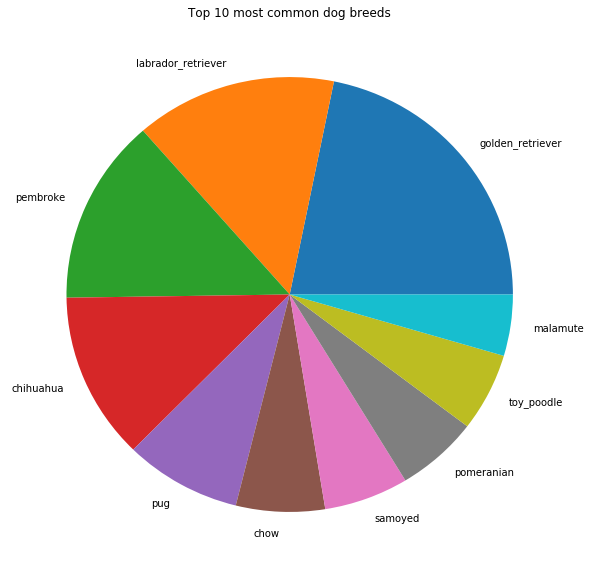

In [34]:
# Display most common dog breeds via pie chart
master_df.first_prediction.value_counts().head(10).plot(kind = 'pie', figsize = (10, 10), title = 'Top 10 most common dog breeds', label = '');

The above pie-chart shows that **Retrievers** are the most common breeds found by the Neural Network

### 3. For which breeds is the algorithm most and least confident in its prediction? 

### Breeds for which the Neural Network is most confident!

In [50]:
true_df = master_df.query('first_dog == True')
print("Breeds for which the algorithm is most confident","\n", true_df.groupby('first_prediction')['first_confidence'].mean().sort_values(ascending = False).head(10))

Breeds for which the algorithm is most confident 
 first_prediction
komondor                0.972531
clumber                 0.946718
brittany_spaniel        0.874545
keeshond                0.844431
bull_mastiff            0.815618
bernese_mountain_dog    0.801816
french_bulldog          0.777413
pug                     0.759223
pomeranian              0.743606
samoyed                 0.740719
Name: first_confidence, dtype: float64


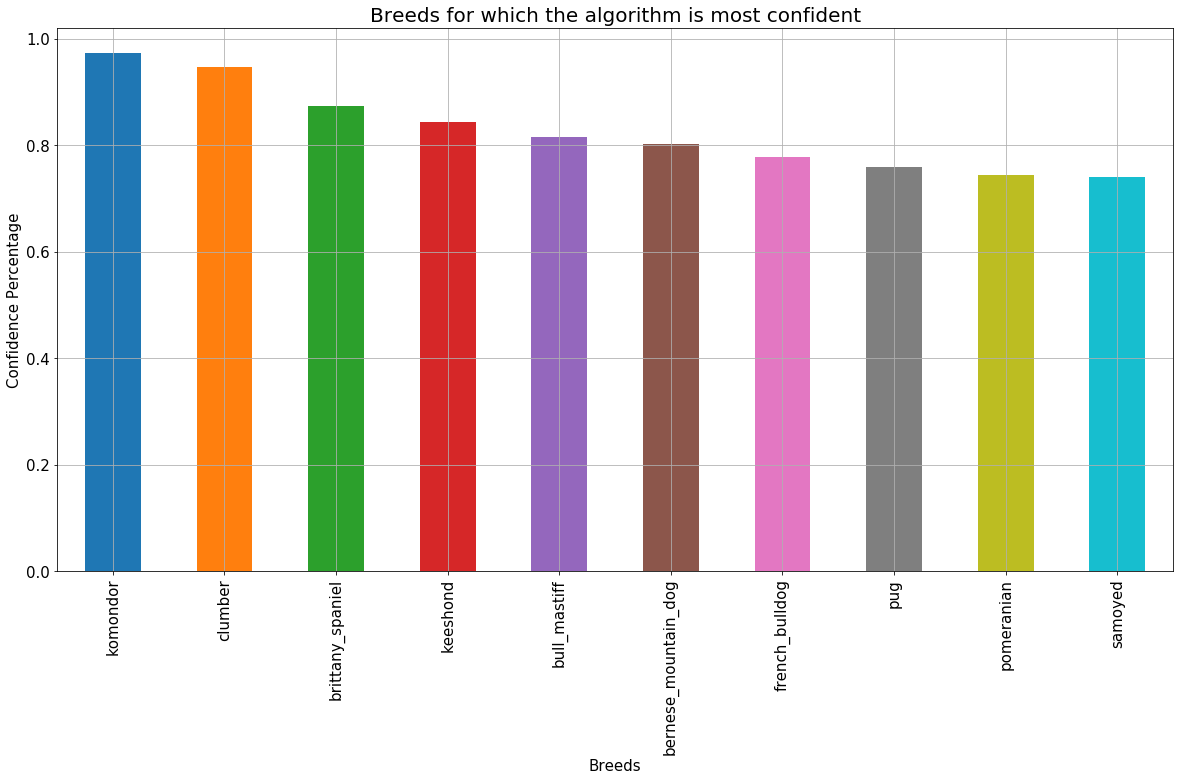

In [39]:
true_df.groupby('first_prediction')['first_confidence'].mean().sort_values(ascending = False).head(10).plot(kind = 'bar', figsize = (20,10), grid = True, fontsize = 15);
plt.title('Breeds for which the algorithm is most confident', fontsize = 20)
plt.xlabel('Breeds', fontsize = 15)
plt.ylabel('Confidence Percentage', fontsize = 15);

**The komondor below certainly can be recognized very confidently due to its uniqueness!!!**

In [49]:
# Assign jpg_url of komondor to a variable
komondor_url = master_df[master_df['first_prediction'] == 'komondor']['jpg_url'].values[0]

# Displays the breed for which the Neural Network is most confident!!!
Image(url = str(komondor_url))

### Breeds for which the Neural Network is least confident!

In [51]:
print("Breeds for which the algorithm is least confident","\n", true_df.groupby('first_prediction')['first_confidence'].mean().sort_values(ascending = False).tail(10))

Breeds for which the algorithm is least confident 
 first_prediction
brabancon_griffon          0.369981
bedlington_terrier         0.340243
norfolk_terrier            0.331407
silky_terrier              0.324251
australian_terrier         0.307584
wire-haired_fox_terrier    0.305596
norwich_terrier            0.295496
scotch_terrier             0.267979
cairn                      0.262196
scottish_deerhound         0.182365
Name: first_confidence, dtype: float64


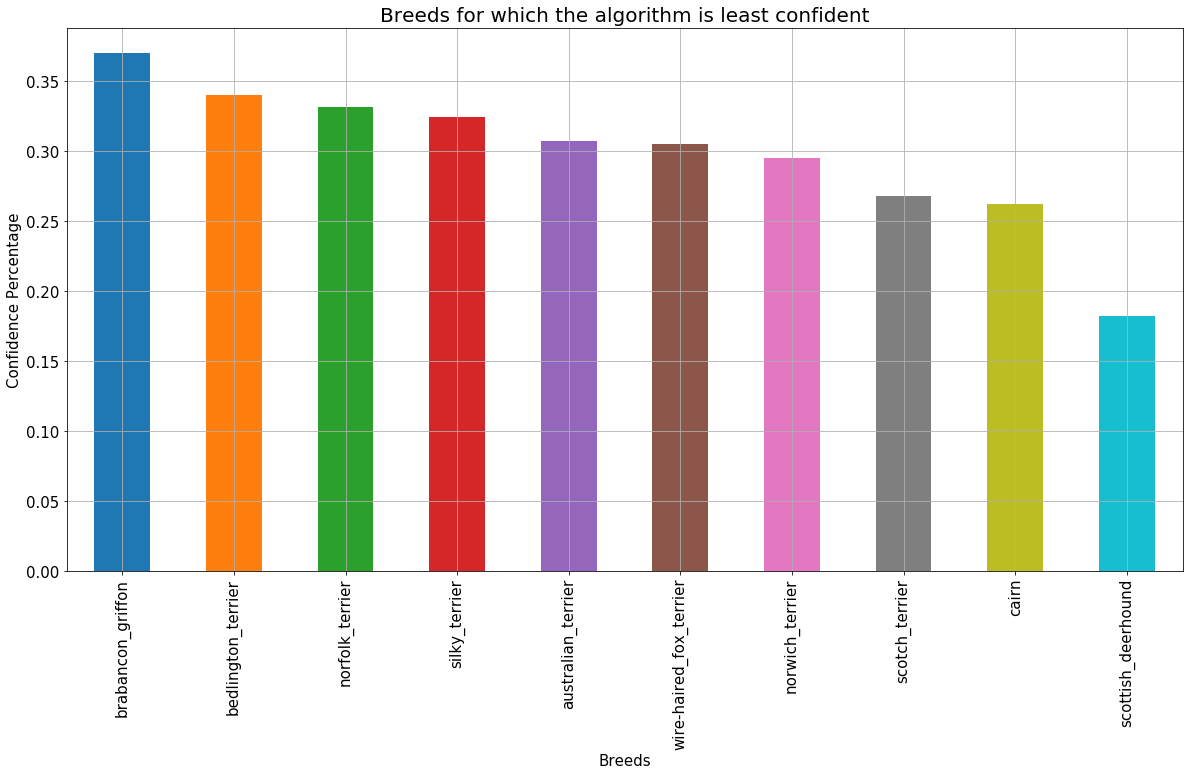

In [40]:
true_df.groupby('first_prediction')['first_confidence'].mean().sort_values(ascending = False).tail(10).plot(kind = 'bar', figsize = (20,10), grid = True, fontsize = 15);
plt.title('Breeds for which the algorithm is least confident', fontsize = 20)
plt.xlabel('Breeds', fontsize = 15)
plt.ylabel('Confidence Percentage', fontsize = 15);

**Well, no doubt the algorithm couldn't recognize it effectively :P**

In [58]:
# Assign jpg_url of scottish_deerhound to a variable
scottish_deerhound_url = master_df[master_df['first_prediction'] == 'scottish_deerhound']['jpg_url'].values[2]

# Displays the breed for which the Neural Network is least confident!!!
Image(url = str(scottish_deerhound_url))

### 4. Which are the most common names of dogs?

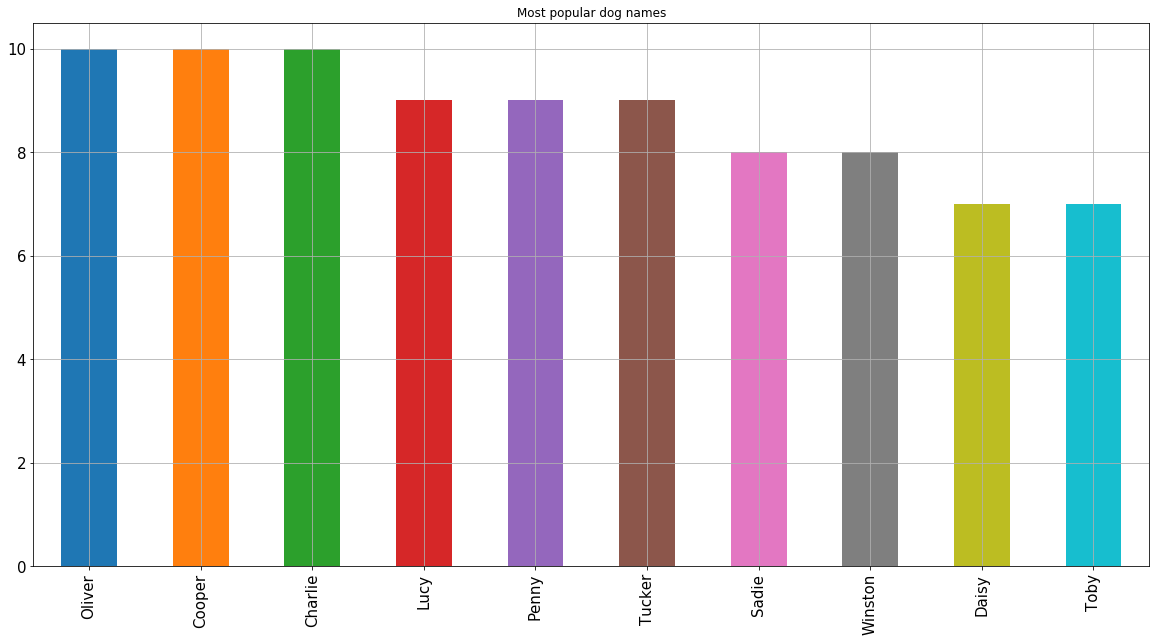

In [172]:
# Displays bar chart with most common dog names
master_df.name.value_counts().head(10).plot(kind = 'bar', figsize = (20,10), grid = True, fontsize = 15, title = 'Most popular dog names').set_ylabel = ('# of dogs');

**Oliver, Cooper, Charlie seems the most popular ones**

### 5. Which dog breeds have the most number of retweets and favorites based on 1st prediction?

In [174]:
# Select True dog breeds
true_breeds = master_df.query('first_dog == True')

In [185]:
# Select necessary columns
most_fav_breeds = true_breeds[['favorites', 'retweets', 'first_prediction']]

In [186]:
# Create dataframe grouped by first prediction
fav_breeds_df = pd.DataFrame(most_fav_breeds.groupby('first_prediction').sum())

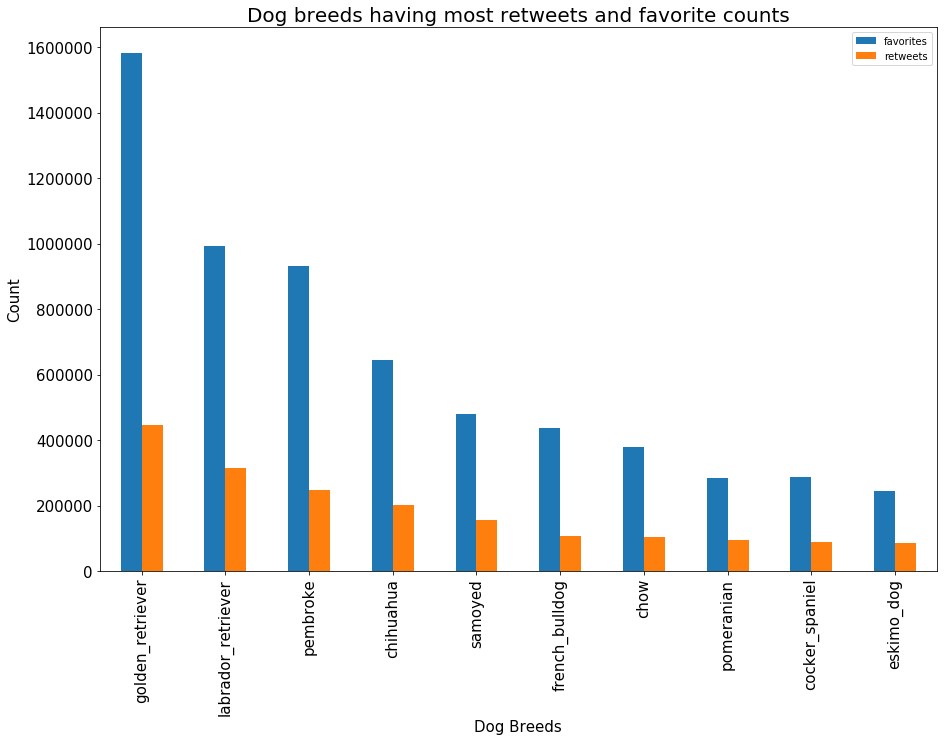

In [197]:
# Plot bar chart for most number of retweets and favorites of Dog breeds
fav_breeds_df = fav_breeds_df.sort_values(by = 'retweets', ascending = False).head(10)
fav_breeds_df.plot(kind = 'bar', figsize = (15, 10), fontsize = 15)
plt.title('Dog breeds having most retweets and favorite counts', size = 20)
plt.xlabel('Dog Breeds', size = 15)
plt.ylabel('Count', size = 15);

**The retrievers win this one too. Probably because they are some of the most common, homely and goodest bois. :D**

<a id='conclusion'></a>
## Conclusions

By gathering, assessing, cleaning and analyzing the dataset, the author was able to answer all the questions posted at the beginning of the document. A few learnings from this project:

- **Gathering** data from API is challenging and requires a lot of effort in terms of finding the right data to writing the code to parse the required data
- **Assessing** data is very important and all the issues needs to be written down in order to efficiently clean the data
- **Cleaning** the dataset is the most time consuming and is a very iterative process. The author had to go to cleaning multiple times during analysis.
- **Analyzing** the dataset to generate valuable insights needs a good understanding of the data and how it can be leveraged to produce meaningful analysis. 
> **Dogs are always good, Brent!!! 13/10**


**All results are limited to the underlying data set and no advaned statistics were performed. One of the major limitations that has to be taken into consideration is that many entries in the dataset have been removed due to missing data. Thus, the results can only be treated as indicators and are not generalizable.**